In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

In [4]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


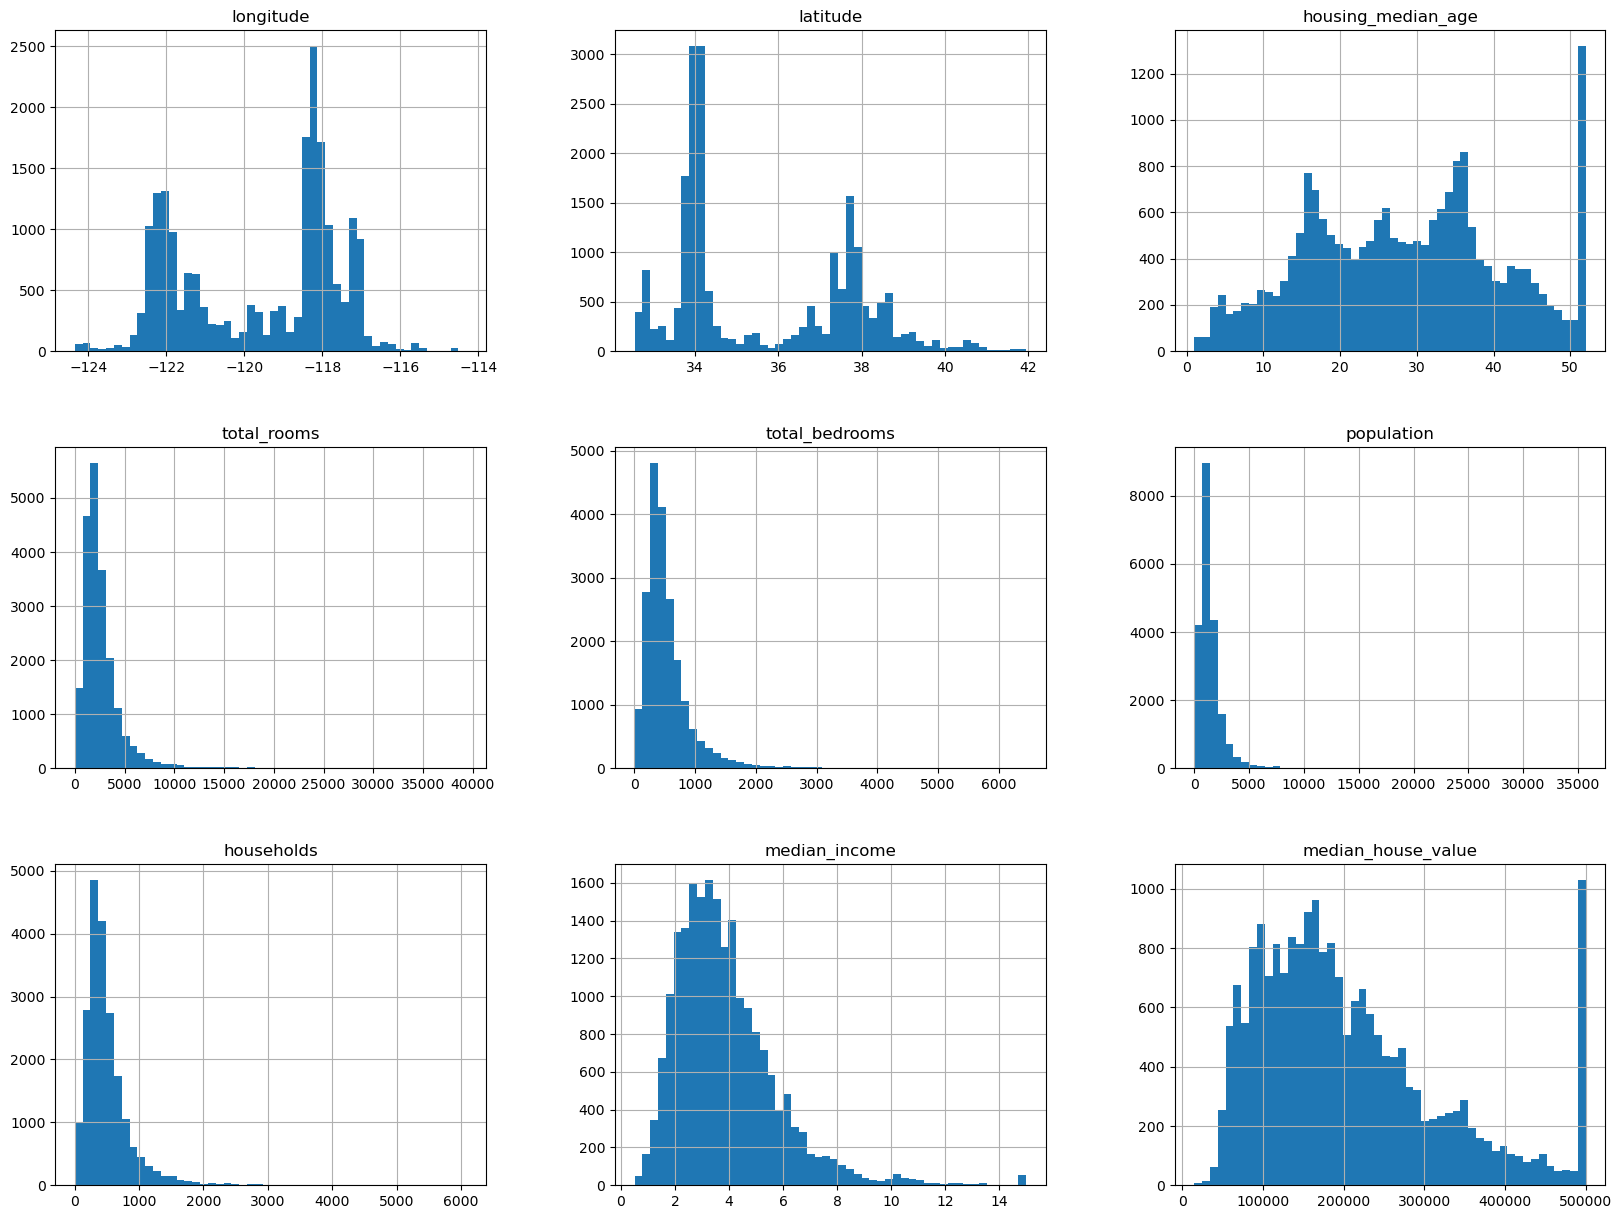

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
housing.hist(bins = 50, figsize = (20,15))
plt.show()

In [10]:
# Create a testset
import numpy as np 

def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [11]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)
len(test_set)

4128

In [12]:
len(train_set)

16512

In [13]:
np.random.seed(42)

In [14]:
from zlib import crc32
# PURPOSE : Determines whether a given identifier belongs to the test set based on a hash value and a specified test ratio.
def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32


# PURPOSE : Splits the dataset into training and test sets based on unique identifiers 
def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

Operation:
- Extracts the identifiers from the specified column in the dataset.

- Applies the is_id_in_test_set function to each identifier to determine if it belongs to the test set.

- Uses the boolean mask in_test_set to split the data into two sets:
    - data.loc[~in_test_set]: The training set (identifiers not in the test set).
    - data.loc[in_test_set]: The test set (identifiers in the test set).


In [15]:
housing_with_id = housing.reset_index()
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

In [16]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

In [17]:
from sklearn.model_selection import train_test_split

train_set, test_split = train_test_split(housing, test_size = 0.2, random_state = 42)

In [18]:
test_set["total_bedrooms"].isnull().sum()

45

In [19]:
from scipy.stats import binom 

sample_size = 1000
ratio_fem = 0.511
prob_too_small = binom(sample_size, ratio_fem).cdf(485-1)
prob_too_large = 1 - binom(sample_size, ratio_fem).cdf(535)
print(prob_too_small + prob_too_large)

0.10736798530929942


In [20]:
#shows another way to estimate the probability of bad sample

np.random.seed(42)

samples = (np.random.rand(100_000, sample_size) < ratio_fem).sum(axis=1)
((samples < 485) | (samples > 535)).mean()

0.1071

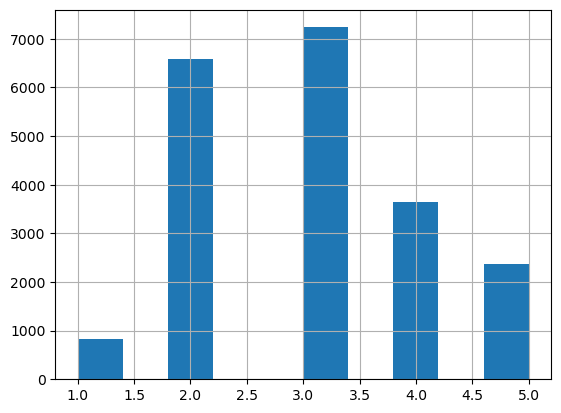

In [21]:
housing["income_cat"] = pd.cut(housing["median_income"],
                              bins = [0., 1.5, 3.0, 4.5, 6.0, np.inf],
                              labels = [1,2,3,4,5])
housing["income_cat"].hist()
plt.show()

In [22]:
from sklearn.model_selection import StratifiedShuffleSplit
# PURPOSE :  This part of the code creates stratified splits of the dataset, ensuring each split has the same distribution of income categories as the original dataset.
splitter = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

In [23]:
strat_train_set, strat_test_set = strat_splits[0]

In [24]:
#This directly creates stratified training and test sets.
strat_train_set, strat_test_set = train_test_split(
    housing, test_size = 0.2, stratify=housing["income_cat"], random_state = 42
)

In [25]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [26]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(housing),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set),
}).sort_index()
compare_props.index.name = "Income Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] /
                                   compare_props["Overall %"] - 1)
compare_props["Rand. Error %"] = (compare_props["Random %"] /
                                  compare_props["Overall %"] - 1)
(compare_props * 100).round(2)

,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Income Category,,,,,
1,3.98,4.00,4.24,0.36,6.45
2,31.88,31.88,30.74,-0.02,-3.59
3,35.06,35.05,34.52,-0.01,-1.53
4,17.63,17.64,18.41,0.03,4.42
5,11.44,11.43,12.09,-0.08,5.63


<Axes: xlabel='longitude', ylabel='latitude'>

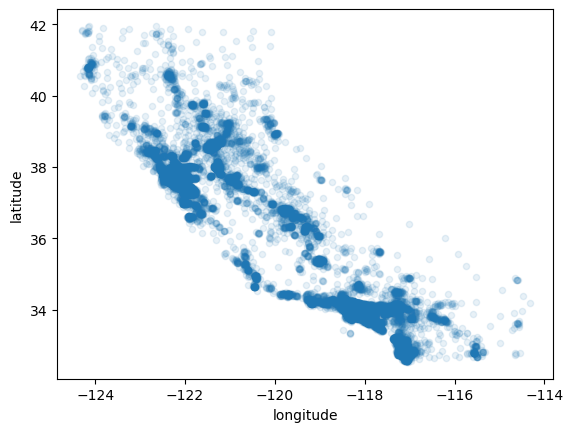

In [27]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.1)

NameError: name 'save_fig' is not defined

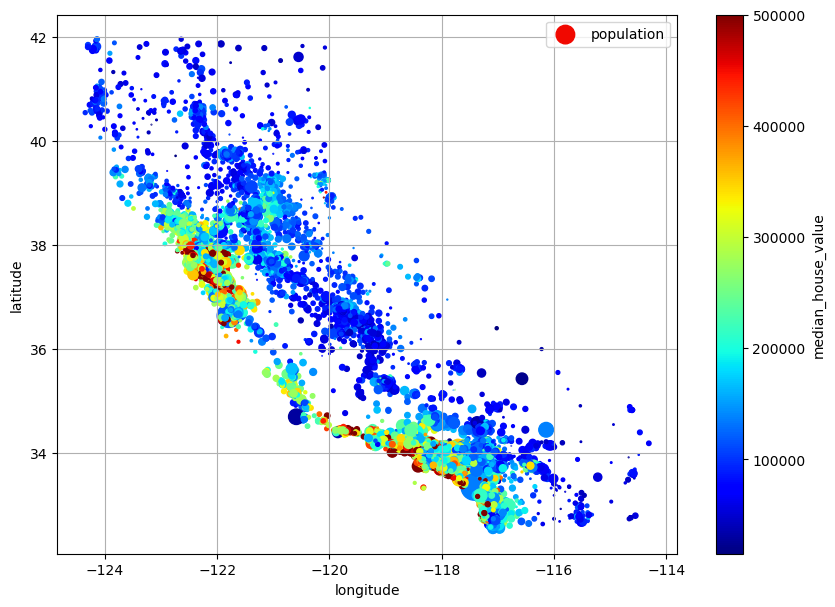

In [28]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude", grid = True, 
             s=housing["population"]/ 100, label = "population", 
             c= "median_house_value", cmap = "jet", colorbar = True,
             legend = True, sharex = False, figsize = (10,7))
save_fig("housing_prices_scatterplot")
plt.show()

## LOOKING FOR CORRELATIONS

In [ ]:
# We are going to find the correlation between every attribute using the .corr method, standard correlation coefficient 

corr_matrix = housing.corr(numeric_only = True)

In [ ]:
corr_matrix["median_house_value"].sort_values(ascending = False)

In [ ]:
from pandas.plotting import scatter_matrix 

attributes  = ["median_house_value", "median_income", "total_rooms", 
               "housing_median_age"]
scatter_matrix(housing[attributes], figsize = (12,8))
save_fig("scatter_matrix_plot")
plt.show()

In [ ]:
housing.plot(kind = "scatter", x = "median_income", y = "median_house_value",
            alpha = 0.1)

## EXPERIMENTING WITH ATTRIBUTES COMBINATIONS 


In [ ]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"] 

In [ ]:
corr_matrix = housing.corr(numeric_only = True)

corr_matrix["median_house_value"].sort_values(ascending = False)

## DATA PREP
Let's revert to the original training set and separate the target (note that strat_train_set.drop() creates a copy of strat_train_set without the column, it doesn't actually modify strat_train_set itself, unless you pass inplace=True):

In [29]:
housing = strat_train_set.drop("median_house_value", axis = 1)
housing_labels = strat_train_set["median_house_value"].copy()

## DATA CLEANING
In the book 3 options are listed to handle the NaN values:

housing.dropna(subset=["total_bedrooms"], inplace=True)    # option 1

housing.drop("total_bedrooms", axis=1)       # option 2

median = housing["total_bedrooms"].median()  # option 3
housing["total_bedrooms"].fillna(median, inplace=True)
For each option, we'll create a copy of housing and work on that copy to avoid breaking housing. We'll also show the output of each option, but filtering on the rows that originally contained a NaN value.

In [30]:
null_rows_idx = housing.isnull().any(axis = 1)
housing.loc[null_rows_idx].head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat
14452,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,3.5962,INLAND,3
18217,-117.96,34.03,35.0,2093.0,NaN,1755.0,403.0,3.4115,<1H OCEAN,3
11889,-118.05,34.04,33.0,1348.0,NaN,1098.0,257.0,4.2917,<1H OCEAN,3
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,<1H OCEAN,4
14360,-117.87,33.62,8.0,1266.0,NaN,375.0,183.0,9.8020,<1H OCEAN,5
17796,-118.31,34.03,47.0,1315.0,NaN,785.0,245.0,1.2300,<1H OCEAN,1
4091,-122.41,38.16,37.0,1549.0,NaN,863.0,275.0,2.7457,NEAR BAY,2
16775,-118.30,33.72,35.0,2790.0,NaN,1167.0,441.0,6.2028,NEAR OCEAN,5
9827,-121.85,36.61,38.0,238.0,NaN,191.0,67.0,1.3897,<1H OCEAN,1
19828,-122.08,37.39,4.0,2292.0,NaN,1050.0,584.0,4.8036,NEAR BAY,4


In [31]:
housing_option1 = housing.copy()

housing_option1.dropna(subset=["total_bedrooms"], inplace=True)  # option 1

housing_option1.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat


In [32]:
housing_option2 = housing.copy()

housing_option2.drop("total_bedrooms", axis=1, inplace=True)  # option 2

housing_option2.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity,income_cat
14452,-120.67,40.50,15.0,5343.0,2503.0,902.0,3.5962,INLAND,3
18217,-117.96,34.03,35.0,2093.0,1755.0,403.0,3.4115,<1H OCEAN,3
11889,-118.05,34.04,33.0,1348.0,1098.0,257.0,4.2917,<1H OCEAN,3
20325,-118.88,34.17,15.0,4260.0,1701.0,669.0,5.1033,<1H OCEAN,4
14360,-117.87,33.62,8.0,1266.0,375.0,183.0,9.8020,<1H OCEAN,5


In [33]:
housing_option3 = housing.copy()
median = housing["total_bedrooms"].median()
housing_option3["total_bedrooms"].fillna(median, inplace = True)

housing_option3.loc[null_rows_idx].head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962,INLAND,3
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115,<1H OCEAN,3
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917,<1H OCEAN,3
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033,<1H OCEAN,4
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020,<1H OCEAN,5


In [34]:
# This option mimics the option 3, but this is a more handy class 
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy = "median")

In [35]:
#seperating out the numerical attributes to use the "median" imputer

housing_num = housing.select_dtypes(include = [np.number])

In [36]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [37]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [38]:
# We can see the median value match the same as option 3 
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [39]:
X = imputer.transform(housing_num)

In [40]:
imputer.feature_names_in_

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

In [41]:
housing_tr = pd.DataFrame(X, columns = housing_num.columns, 
                          index = housing_num.index)

In [42]:
housing_tr.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020


In [43]:
# Utilize if outliers is a problem in future

from sklearn.ensemble import IsolationForest
isolation_forest = IsolationForest(random_state = 42)
outlier_pred = isolation_forest.fit_predict(X)

In [44]:
outlier_pred

array([-1,  1,  1, ...,  1,  1,  1])

## Handling Text and Categorical Attributes 

In [45]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


In [46]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [47]:
housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

In [48]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [49]:
from sklearn.preprocessing import OneHotEncoder 
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [50]:
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [51]:
#By default, the OneHotEncoder class returns a sparse array, but we can convert it to a dense array if needed by calling the toarray() method:

housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [52]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [53]:
df_test = pd.DataFrame({"ocean_proximity" : ['INLAND','NEAR BAY']})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,True,False
1,False,True


In [54]:
cat_encoder.transform(df_test).toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [55]:
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "ISLAND"]})
pd.get_dummies(df_test_unknown)

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,True,False
1,False,True


In [56]:
cat_encoder.handle_unknown = "ignore"
cat_encoder.transform(df_test_unknown).toarray()

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [57]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [58]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [59]:
cat_encoder.handle_unknown = "ignore"
cat_encoder.transform(df_test_unknown)

<2x5 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

## Feature Scaling 

In [60]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range = (-1,1))
housing_num_min_max = min_max_scaler.fit_transform(housing_num)

In [61]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaler = std_scaler.fit_transform(housing_num)

NameError: name 'save_fig' is not defined

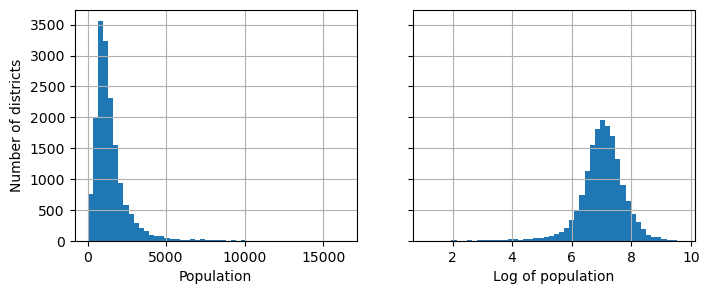

In [62]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
housing["population"].hist(ax=axs[0], bins=50)
housing["population"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")
save_fig("long_tail_plot")
plt.show()

In [73]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)

NameError: name 'save_fig' is not defined

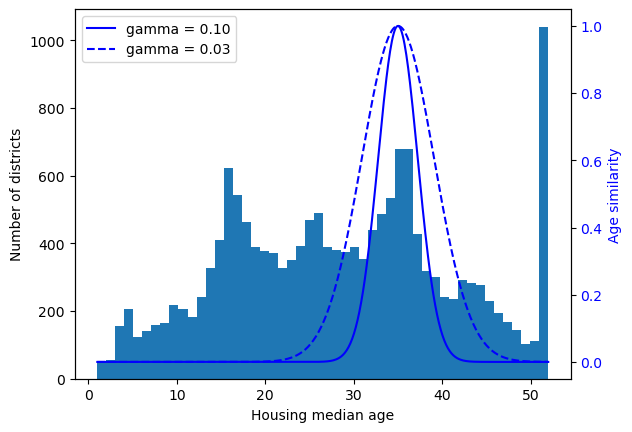

In [74]:
ages = np.linspace(housing["housing_median_age"].min(),
                   housing["housing_median_age"].max(),
                   500).reshape(-1, 1)
gamma1 = 0.1
gamma2 = 0.03
rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma=gamma2)

fig, ax1 = plt.subplots()

ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(housing["housing_median_age"], bins=50)

ax2 = ax1.twinx()  # create a twin axis that shares the same x-axis
color = "blue"
ax2.plot(ages, rbf1, color=color, label="gamma = 0.10")
ax2.plot(ages, rbf2, color=color, label="gamma = 0.03", linestyle="--")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("Age similarity", color=color)

plt.legend(loc="upper left")
save_fig("age_similarity_plot")
plt.show()

^^The plot helps visualize how the similarity of housing median ages to a specific value (35) changes with different gamma values. The gamma parameter controls the width of the RBF kernel. A larger gamma value results in a narrower kernel, meaning that only points very close to 35 will have high similarity. A smaller gamma value results in a wider kernel, meaning that more points will have higher similarity to 35.

Use Case: This is useful in understanding the effect of the gamma parameter in RBF kernels, which is critical for kernel-based methods such as Support Vector Machines (SVMs) and kernelized regression methods. By adjusting gamma, you can control the sensitivity of the model to changes in the data, affecting model performance and generalization.

The goal of your code is to train a linear regression model to predict housing prices based on the median income. The housing prices are scaled before training to improve the model's performance. After making predictions on new data, the predictions are scaled back to the original scale.

In [75]:
from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].loc[:5] #pretend this the new data

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

In [76]:
predictions

array([[131997.15275877],
       [299359.35844434],
       [146023.37185694],
       ...,
       [205216.28212824],
       [ 88063.99685781],
       [213313.97966323]])

In [77]:
# Cleaner and simplified workflow, this approach encapsulates the target transformation logic within the model, making the training and prediction steps cleaner and more maintainable. 

from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(),
                                   transformer = StandardScaler())
model.fit(housing[["median_income"]], housing_labels)
prediction = model.predict(some_new_data)

In [78]:
prediction

array([131997.15275877, 299359.35844434, 146023.37185694, ...,
       205216.28212824,  88063.99685781, 213313.97966323])

## Custom Transformers


In [79]:
from sklearn.preprocessing import FunctionTransformer 
# Define log transformer
log_transformer = FunctionTransformer(np.log, inverse_func = np.exp)
log_pop = log_transformer.transform(housing[["population"]])

In [80]:
# Define RBF transformer for housing age similarity to 35
rbf_transformer = FunctionTransformer(rbf_kernel,
                                    kw_args = dict(Y = [[35.]], gamma = 0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])

In [81]:
age_simil_35

array([[2.81118530e-13],
       [8.20849986e-02],
       [6.70320046e-01],
       ...,
       [9.55316054e-22],
       [6.70320046e-01],
       [3.03539138e-04]])

In [82]:
# Define coordinates for San Francisco and create transformer
sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel,
                                     kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.transform(housing[["latitude", "longitude"]])

In [83]:
sf_simil

array([[0.999927  ],
       [0.05258419],
       [0.94864161],
       ...,
       [0.00388525],
       [0.05038518],
       [0.99868067]])

In [84]:
# Define ratio transformer
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transformer.transform(np.array([[1., 2.], [3., 4.]]))

array([[0.5 ],
       [0.75]])

In [85]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean = True):
        self.with_mean = with_mean


    def fit(self, X, y = None):
        X = check_array(X)
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]
        return self

    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X/ self.scale_

In [86]:
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, n_init=10,
                              random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [87]:
cluster_simil = ClusterSimilarity(n_clusters = 10, gamma = 1. , random_state = 42)

similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]],
                                           sample_weight = housing_labels)


In [88]:
similarities[:3].round(2)

array([[0.  , 0.14, 0.  , 0.  , 0.  , 0.08, 0.  , 0.99, 0.  , 0.6 ],
       [0.63, 0.  , 0.99, 0.  , 0.  , 0.  , 0.04, 0.  , 0.11, 0.  ],
       [0.  , 0.29, 0.  , 0.  , 0.01, 0.44, 0.  , 0.7 , 0.  , 0.3 ]])

NameError: name 'save_fig' is not defined

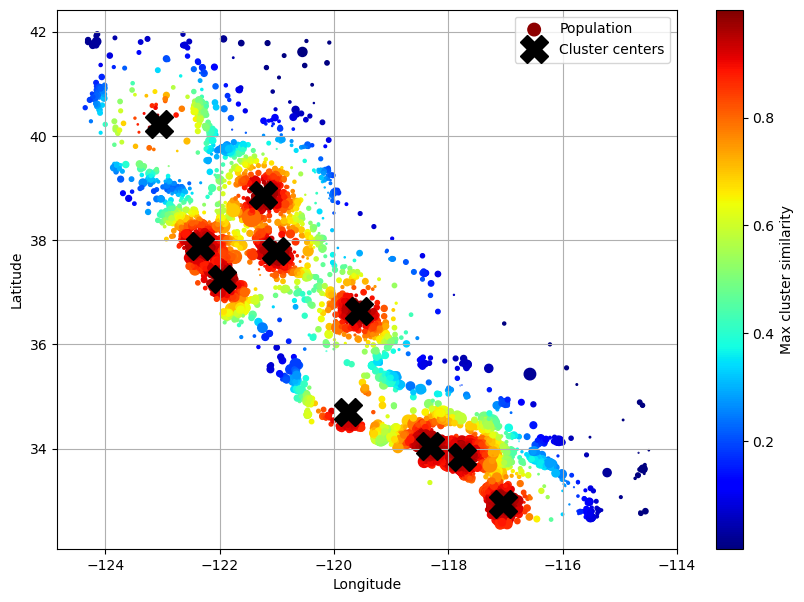

In [89]:
housing_renamed = housing.rename(columns= { "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})

housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind = "scatter", x = "Longitude", y = "Latitude", grid = True, 
                     s = housing_renamed["Population"] / 100, label = "Population",
                     c = "Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")
save_fig("district_cluster_plot")
plt.show()

## Transformation Pipelines

In [90]:
from sklearn.pipeline import Pipeline 

num_pipline  = Pipeline([
    ("impute", SimpleImputer(strategy = "median")),
    ("standardize", StandardScaler()),
])

In [91]:
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy = "median"), StandardScaler())

In [92]:
from sklearn import set_config

set_config(display='diagram')

num_pipeline


Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [93]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

In [94]:
def monkey_patch_get_signature_names_out():
    """Monkey patch some classes which did not handle get_feature_names_out()
       correctly in Scikit-Learn 1.0.*."""
    from inspect import Signature, signature, Parameter
    import pandas as pd
    from sklearn.impute import SimpleImputer
    from sklearn.pipeline import make_pipeline, Pipeline
    from sklearn.preprocessing import FunctionTransformer, StandardScaler

    default_get_feature_names_out = StandardScaler.get_feature_names_out

    if not hasattr(SimpleImputer, "get_feature_names_out"):
      print("Monkey-patching SimpleImputer.get_feature_names_out()")
      SimpleImputer.get_feature_names_out = default_get_feature_names_out

    if not hasattr(FunctionTransformer, "get_feature_names_out"):
        print("Monkey-patching FunctionTransformer.get_feature_names_out()")
        orig_init = FunctionTransformer.__init__
        orig_sig = signature(orig_init)

        def __init__(*args, feature_names_out=None, **kwargs):
            orig_sig.bind(*args, **kwargs)
            orig_init(*args, **kwargs)
            args[0].feature_names_out = feature_names_out

        __init__.__signature__ = Signature(
            list(signature(orig_init).parameters.values()) + [
                Parameter("feature_names_out", Parameter.KEYWORD_ONLY)])

        def get_feature_names_out(self, names=None):
            if callable(self.feature_names_out):
                return self.feature_names_out(self, names)
            assert self.feature_names_out == "one-to-one"
            return default_get_feature_names_out(self, names)

        FunctionTransformer.__init__ = __init__
        FunctionTransformer.get_feature_names_out = get_feature_names_out

monkey_patch_get_signature_names_out()


In [95]:
df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared, columns=num_pipeline.get_feature_names_out(),
    index=housing_num.index)
df_housing_num_prepared.head(2)  # extra code

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942


In [96]:
num_pipeline.steps

[('simpleimputer', SimpleImputer(strategy='median')),
 ('standardscaler', StandardScaler())]

In [97]:
num_pipeline[:-1]

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median'))])

In [98]:
num_pipeline.set_params(simpleimputer__strategy="median")

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [99]:
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

In [100]:
from sklearn.compose import make_column_selector, make_column_transformer 

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include = np.number)),
    (cat_pipeline, make_column_selector(dtype_include = object)),
)

In [101]:
housing_prepared = preprocessing.fit_transform(housing)

In [102]:
# extra code – shows that we can get a DataFrame out if we want
housing_prepared_fr = pd.DataFrame(
    housing_prepared,
    columns=preprocessing.get_feature_names_out(),
    index=housing.index)
housing_prepared_fr.head(2)


,pipeline-1__longitude,pipeline-1__latitude,pipeline-1__housing_median_age,pipeline-1__total_rooms,pipeline-1__total_bedrooms,pipeline-1__population,pipeline-1__households,pipeline-1__median_income,pipeline-2__ocean_proximity_<1H OCEAN,pipeline-2__ocean_proximity_INLAND,pipeline-2__ocean_proximity_ISLAND,pipeline-2__ocean_proximity_NEAR BAY,pipeline-2__ocean_proximity_NEAR OCEAN
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491,0.0,0.0,0.0,1.0,0.0
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942,1.0,0.0,0.0,0.0,0.0


In [103]:
def column_ratio(X):
    return X[:, [0]] / X[:,[1]]

def ratio_name(funtion_transformer, feature_names_in):
    return ["ratio"]

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy = "median"),
        FunctionTransformer(column_ratio, feature_names_out = ratio_name),
        StandardScaler())
log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)  # one column remaining: housing_median_age

In [104]:
housing_prepared =  preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 25)

In [105]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age', 'remainder__income_cat'],
      dtype=object)

# Select and train the model 

## Training and evaluating on the training set  

In [106]:
# we will first attempt to select a simple model such as linear regression model 

from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000027608460DD0>)])),
                ('linearregression', LinearRegression())])

In [107]:
housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2)   # -2 means to round to the nearest hundred

array([248000., 394100., 120700.,  90800., 330400.])

In [108]:
# Compare against the actual values 

housing_labels.iloc[:5].values

array([458300., 483800., 101700.,  96100., 361800.])

In [109]:
error_ratios = housing_predictions[:5].round(-2) / housing_labels.iloc[:5].values - 1
print(", ".join([f"{100 * ratio:.1f}%" for ratio in error_ratios]))

-45.9%, -18.5%, 18.7%, -5.5%, -8.7%


In [110]:
from sklearn.metrics import mean_squared_error

lin_rmse = mean_squared_error(housing_labels, housing_predictions,
                              squared = False)
lin_rmse

68047.65529482749

In [111]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state = 42))

tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000027608460DD0>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [112]:
housing_predictions = tree_reg.predict(housing)

tree_rmse = mean_squared_error(housing_labels, housing_predictions,
                               squared = False)

In [113]:
tree_rmse

0.0

## Better evaluation Using cross-validation

In [114]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels,
                             scoring = "neg_root_mean_squared_error", cv = 10)

In [115]:
pd.Series(tree_rmses).describe()

count       10.000000
mean     66791.264537
std       1949.313791
min      64467.336441
25%      65232.401617
50%      65950.821214
75%      68417.300416
max      70051.355051
dtype: float64

In [116]:
lin_rmse = -cross_val_score(lin_reg, housing, housing_labels,
                            scoring = "neg_root_mean_squared_error", cv = 10)
pd.Series(lin_rmse).describe()

count       10.000000
mean     69104.202979
std       3782.877757
min      64812.478738
25%      67456.796891
50%      68303.471406
75%      69289.258468
max      78930.111876
dtype: float64

In [117]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing, 
                           RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg,housing, housing_labels,
                               scoring = "neg_root_mean_squared_error", cv = 10)


In [118]:
pd.Series(forest_rmses).describe()

count       10.000000
mean     47042.341721
std       1056.004286
min      45574.447034
25%      46507.787732
50%      46891.828872
75%      47346.956322
max      49424.336447
dtype: float64

In [119]:
forest_reg.fit(housing, housing_labels)

housing_predictions = forest_reg.predict(housing)

forest_rmse = mean_squared_error(housing_labels, housing_predictions,
                                squared = False)

forest_rmse


17525.13783819652

The training error is much lower than the validation error, which usually means that the model has overfit the training set. Another possible explanation may be that there's a mismatch between the training data and the validation data, but it's not the case here, since both came from the same dataset that we shuffled and split in two parts.



# FIne tune model
## grid search 

In [120]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state = 42)),
])

param_grid = [
    {"preprocessing__geo__n_clusters": [5,8,10],
     "random_forest__max_features" : [4,6,8]
    },
    {"preprocessing__geo__n_clusters": [10,15],
     "random_forest__max_features" : [6,8,10]
        
    }
]

grid_search = GridSearchCV(full_pipeline, param_grid, cv = 3,
                           scoring = "neg_root_mean_squared_error")

grid_search.fit(housing, housing_labels)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000027608460DD0>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [121]:
print(str(full_pipeline.get_params().keys())[:1000]+"...")

dict_keys(['memory', 'steps', 'verbose', 'preprocessing', 'random_forest', 'preprocessing__n_jobs', 'preprocessing__remainder__memory', 'preprocessing__remainder__steps', 'preprocessing__remainder__verbose', 'preprocessing__remainder__simpleimputer', 'preprocessing__remainder__standardscaler', 'preprocessing__remainder__simpleimputer__add_indicator', 'preprocessing__remainder__simpleimputer__copy', 'preprocessing__remainder__simpleimputer__fill_value', 'preprocessing__remainder__simpleimputer__keep_empty_features', 'preprocessing__remainder__simpleimputer__missing_values', 'preprocessing__remainder__simpleimputer__strategy', 'preprocessing__remainder__simpleimputer__verbose', 'preprocessing__remainder__standardscaler__copy', 'preprocessing__remainder__standardscaler__with_mean', 'preprocessing__remainder__standardscaler__with_std', 'preprocessing__remainder', 'preprocessing__sparse_threshold', 'preprocessing__transformer_weights', 'preprocessing__transformers', 'preprocessing__verbose'

In [122]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [123]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x0000027...
                                                  ClusterSimilarity(n_clusters=15,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000027608484C10>)])),
                ('random_forest',
                 RandomForestRegressor(max_features=6, random_state=42))])

In [124]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending = False, inplace = True)

cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_col = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_col
cv_res[score_col] = -cv_res[score_col].round().astype(np.int64)

cv_res.head()


,n_clusters,max_features,split0,split1,split2,mean_test_rmse
12,15,6,44482,44668,45623,44925
13,15,8,44648,45010,45673,45110
14,15,10,45104,44947,46130,45394
6,10,4,45624,45563,46581,45923
7,10,6,45583,45619,46820,46007


# Randomized Search 

In [125]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

In [126]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint 

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions = param_distribs, n_iter = 10, cv = 3,
    scoring = "neg_root_mean_squared_error", random_state = 42)

rnd_search.fit(housing, housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002760851FC50>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000276084AF6D0>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [127]:
# extra code – displays the random search results
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
cv_res.columns = ["n_clusters", "max_features"] + score_col
cv_res[score_col] = -cv_res[score_col].round().astype(np.int64)
cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
1,45,9,42169,42494,43358,42674
5,42,4,41939,42739,44010,42896
8,32,7,42348,43081,44006,43145
0,41,16,43236,43661,44268,43721
2,23,8,43402,43634,44489,43842


## Bonus section: how to choose the sampling distribution for a hyperparameter

scipy.stats.randint(a, b+1): for hyperparameters with discrete values that range from a to b, and all values in that range seem equally likely.
scipy.stats.uniform(a, b): this is very similar, but for continuous hyperparameters.
scipy.stats.geom(1 / scale): for discrete values, when you want to sample roughly in a given scale. E.g., with scale=1000 most samples will be in this ballpark, but ~10% of all samples will be <100 and ~10% will be >2300.
scipy.stats.expon(scale): this is the continuous equivalent of geom. Just set scale to the most likely value.
scipy.stats.loguniform(a, b): when you have almost no idea what the optimal hyperparameter value's scale is. If you set a=0.01 and b=100, then you're just as likely to sample a value between 0.01 and 0.1 as a value between 10 an 100.
Here are plots of the probability mass functions (for discrete variables), and probability density functions (for continuous variables) for randint(), uniform(), geom() and expon():xpon():

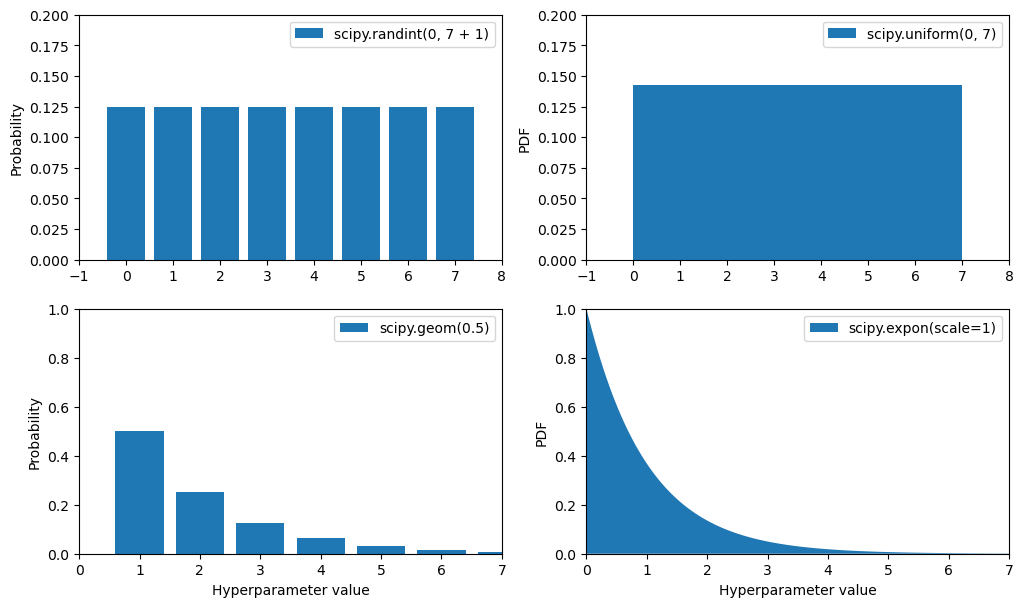

In [128]:
# extra code – plots a few distributions you can use in randomized search

from scipy.stats import randint, uniform, geom, expon

xs1 = np.arange(0, 7 + 1)
randint_distrib = randint(0, 7 + 1).pmf(xs1)

xs2 = np.linspace(0, 7, 500)
uniform_distrib = uniform(0, 7).pdf(xs2)

xs3 = np.arange(0, 7 + 1)
geom_distrib = geom(0.5).pmf(xs3)

xs4 = np.linspace(0, 7, 500)
expon_distrib = expon(scale=1).pdf(xs4)

plt.figure(figsize=(12, 7))

plt.subplot(2, 2, 1)
plt.bar(xs1, randint_distrib, label="scipy.randint(0, 7 + 1)")
plt.ylabel("Probability")
plt.legend()
plt.axis([-1, 8, 0, 0.2])

plt.subplot(2, 2, 2)
plt.fill_between(xs2, uniform_distrib, label="scipy.uniform(0, 7)")
plt.ylabel("PDF")
plt.legend()
plt.axis([-1, 8, 0, 0.2])

plt.subplot(2, 2, 3)
plt.bar(xs3, geom_distrib, label="scipy.geom(0.5)")
plt.xlabel("Hyperparameter value")
plt.ylabel("Probability")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.subplot(2, 2, 4)
plt.fill_between(xs4, expon_distrib, label="scipy.expon(scale=1)")
plt.xlabel("Hyperparameter value")
plt.ylabel("PDF")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.show()

Here are the PDF for expon() and loguniform() (left column), as well as the PDF of log(X) (right column). The right column shows the distribution of hyperparameter scales. You can see that expon() favors hyperparameters with roughly the desired scale, with a longer tail towards the smaller scales. But loguniform() does not favor any scale, they are all equally likely:

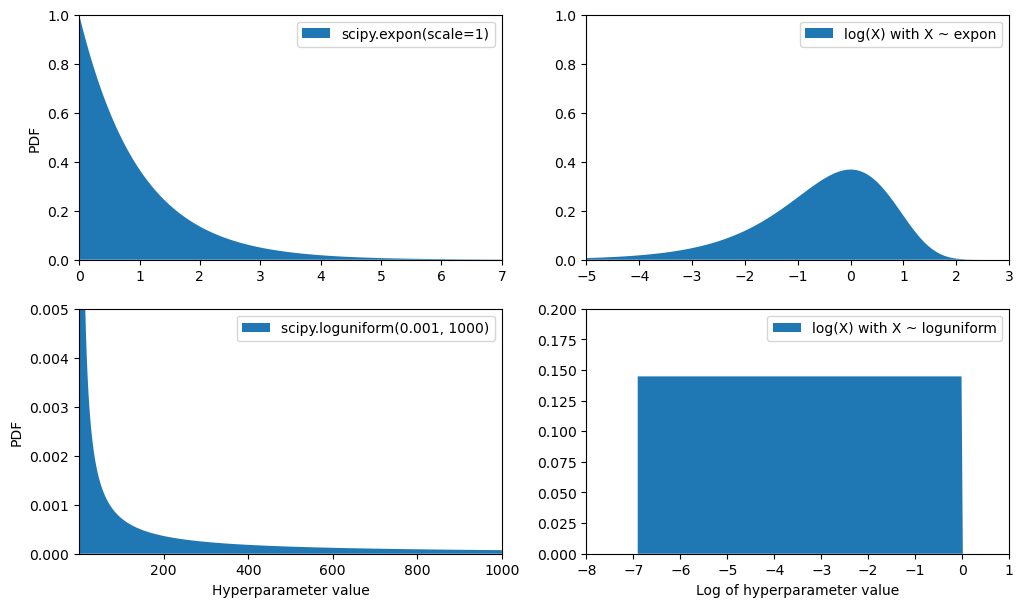

In [129]:
# extra code – shows the difference between expon and loguniform

from scipy.stats import loguniform

xs1 = np.linspace(0, 7, 500)
expon_distrib = expon(scale=1).pdf(xs1)

log_xs2 = np.linspace(-5, 3, 500)
log_expon_distrib = np.exp(log_xs2 - np.exp(log_xs2))

xs3 = np.linspace(0.001, 1000, 500)
loguniform_distrib = loguniform(0.001, 1000).pdf(xs3)

log_xs4 = np.linspace(np.log(0.001), np.log(1000), 500)
log_loguniform_distrib = uniform(np.log(0.001), np.log(1000)).pdf(log_xs4)

plt.figure(figsize=(12, 7))

plt.subplot(2, 2, 1)
plt.fill_between(xs1, expon_distrib,
                 label="scipy.expon(scale=1)")
plt.ylabel("PDF")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.subplot(2, 2, 2)
plt.fill_between(log_xs2, log_expon_distrib,
                 label="log(X) with X ~ expon")
plt.legend()
plt.axis([-5, 3, 0, 1])

plt.subplot(2, 2, 3)
plt.fill_between(xs3, loguniform_distrib,
                 label="scipy.loguniform(0.001, 1000)")
plt.xlabel("Hyperparameter value")
plt.ylabel("PDF")
plt.legend()
plt.axis([0.001, 1000, 0, 0.005])

plt.subplot(2, 2, 4)
plt.fill_between(log_xs4, log_loguniform_distrib,
                 label="log(X) with X ~ loguniform")
plt.xlabel("Log of hyperparameter value")
plt.legend()
plt.axis([-8, 1, 0, 0.2])

plt.show()


## Analyze the Best Model and Their Errors

In [130]:
final_model = rnd_search.best_estimator_   #includes preprocessing
feature_importances = final_model["random_forest"].feature_importances_

feature_importances.round(2)

array([0.05, 0.04, 0.05, 0.01, 0.01, 0.01, 0.01, 0.15, 0.03, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.  , 0.01, 0.  , 0.01, 0.01, 0.01, 0.  , 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.01, 0.01, 0.01, 0.01, 0.02,
       0.01, 0.  , 0.01, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01, 0.  , 0.06,
       0.  , 0.  , 0.  , 0.01, 0.13])

In [131]:
sorted(zip(feature_importances, 
          final_model["preprocessing"].get_feature_names_out()),
       reverse=True)

[(0.15365254035279347, 'log__median_income'),
 (0.1262314446578157, 'remainder__income_cat'),
 (0.06225363455655132, 'cat__ocean_proximity_INLAND'),
 (0.051612484273610544, 'people_per_house__ratio'),
 (0.04931427487153142, 'bedrooms__ratio'),
 (0.0408096282881476, 'rooms_per_house__ratio'),
 (0.030714748001953073, 'geo__Cluster 0 similarity'),
 (0.02448402798091465, 'geo__Cluster 24 similarity'),
 (0.01992464986034005, 'geo__Cluster 43 similarity'),
 (0.0192890353113088, 'geo__Cluster 28 similarity'),
 (0.0189308652836578, 'geo__Cluster 34 similarity'),
 (0.014589499014575047, 'geo__Cluster 20 similarity'),
 (0.01410459325494003, 'geo__Cluster 27 similarity'),
 (0.013860673585194319, 'geo__Cluster 37 similarity'),
 (0.012963407439335588, 'geo__Cluster 31 similarity'),
 (0.012863131131503797, 'geo__Cluster 39 similarity'),
 (0.012684138729491095, 'remainder__housing_median_age'),
 (0.012201511063904715, 'geo__Cluster 3 similarity'),
 (0.012161440865341166, 'geo__Cluster 4 similarity'),

# Evaluate your system on the test set

In [132]:
X_test = strat_test_set.drop("median_house_value", axis = 1)

y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared = False)
print(final_rmse)

42002.456469814824


In [133]:
# We can compute a 95% confidence interval for the test RMSE:


from scipy import stats

confidence = 0.95
squared_error = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_error) - 1,
                         loc = squared_error.mean(),
                         scale = stats.sem(squared_error)))

array([39844.20607027, 44055.10119869])

In [134]:
# extra code – shows how to compute a confidence interval for the RMSE
m = len(squared_error)
mean = squared_error.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_error.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(39844.20607027217, 44055.10119869281)

In [135]:
# extra code – computes a confidence interval again using a z-score
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_error.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(39844.8561755573, 44054.513223352405)

In [136]:
import joblib

joblib.dump(final_model, "my_california_housing_model.pkl")

['my_california_housing_model.pkl']

In [137]:
import joblib

# extra code – excluded for conciseness
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

#class ClusterSimilarity(BaseEstimator, TransformerMixin):
#    [...]

final_model_reloaded = joblib.load("my_california_housing_model.pkl")

new_data = housing.iloc[:5]  # pretend these are new districts
predictions = final_model_reloaded.predict(new_data)

In [138]:
predictions

array([439508.11, 459585.07, 104427.  , 100394.  , 340942.03])

1. Exercise: Try a Support Vector Machine regressor (sklearn.svm.SVR) with various hyperparameters, such as kernel="linear" (with various values for the C hyperparameter) or kernel="rbf" (with various values for the C and gamma hyperparameters). Note that SVMs don't scale well to large datasets, so you should probably train your model on just the first 5,000 instances of the training set and use only 3-fold cross-validation, or else it will take hours. Don't worry about what the hyperparameters mean for now (see the SVM notebook if you're interested). How does the best SVR predictor perform?

In [139]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

param_grid = [
        {'svr__kernel': ['linear'], 'svr__C': [10.,30., 100., 300., 1000.,
                                           3000., 10000., 30000.0]},
        {'svr__kernel': ['rbf'], 'svr__C': [1.0,3.0, 10., 30., 100.,300.,
                                            1000.0],
        'svr__gamma' : [0.01,0.03,0.1, 0.3, 1.0, 3.0]},
    ]

svr_pipeline = Pipeline([("preprocessing", preprocessing), ("svr", SVR())])
grid_search = GridSearchCV(svr_pipeline,param_grid, cv = 3,
                           scoring = 'neg_root_mean_squared_error')
grid_search.fit(housing.iloc[:5000], housing_labels.iloc[:5000])



GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000027608460DD0>)])),
                                       ('svr', SVR())]),
             param_grid=[{'svr__C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0,
                                     10000.0, 30000.0],
                          'svr__kernel': ['linear']},
                         {'svr__C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0,
                                     1000.0],
                          'svr__gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'svr__kernel': ['rbf']}],
             scoring='neg_root_mean_squared_error')

In [140]:
svr_grid_search_rmse = -grid_search.best_score_

svr_grid_search_rmse

69062.06519942232

In [141]:
grid_search.best_params_

{'svr__C': 10000.0, 'svr__kernel': 'linear'}

2.
Exercise: Try replacing the GridSearchCV with a RandomizedSearchCV.

Warning: the following cell will take several minutes to run. You can specify verbose=2 when creating the RandomizedSearchCV if you want to see the training details.

In [142]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, loguniform
# see https://docs.scipy.org/doc/scipy/reference/stats.html
# for `expon()` and `loguniform()` documentation and more probability distribution functions.
# Note: gamma is ignored when kernel is "linear"

param_distribs = {
    'svr__kernel': ['linear', 'rbf'],
    'svr__C' : loguniform(20,200_000),
    'svr__gamma' : expon(scale = 1.0),
}

rnd_search = RandomizedSearchCV(svr_pipeline, 
                               param_distributions = param_distribs,
                               n_iter = 50, cv = 3,
                               scoring = 'neg_root_mean_squared_error',
                               random_state = 42)

rnd_search.fit(housing.iloc[:5000], housing_labels.iloc[:5000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x0000027608460DD0>)])),
                                             ('svr', SVR())]),
                   n_iter=50,
                   param_distributions={'svr__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000027608E90350>,
                                        'svr__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000027608E1A550>,
                                        'svr__kernel': ['linear', 'rbf']},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [143]:
svr_rnd_search_rmse = -rnd_search.best_score_

In [144]:
rnd_search.best_params_

{'svr__C': 157055.10989448498,
 'svr__gamma': 0.26497040005002437,
 'svr__kernel': 'rbf'}

This time the search found a good set of hyperparameters for the RBF kernel. Randomized search tends to find better hyperparameters than grid search in the same amount of time.

Note that we used the expon() distribution for gamma, with a scale of 1, so RandomSearch mostly searched for values roughly of that scale: about 80% of the samples were between 0.1 and 2.3 (roughly 10% were smaller and 10% were larger):

In [145]:
np.random.seed(42)

s = expon(scale = 1).rvs(100_000)
((s > 0.105) & (s < 0.229)).sum()/ 100_000

0.1049

3.
Exercise: Try adding a SelectFromModel transformer in the preparation pipeline to select only the most important attributes.

Let's create a new pipeline that runs the previously defined preparation pipeline, and adds a SelectFromModel transformer based on a RandomForestRegressor before the final regressor:

In [146]:
from sklearn.feature_selection import SelectFromModel

selector_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('selector', SelectFromModel(RandomForestRegressor(random_state=42),
                                 threshold=0.005)),  # min feature importance
    ('svr', SVR(C=rnd_search.best_params_["svr__C"],
                gamma=rnd_search.best_params_["svr__gamma"],
                kernel=rnd_search.best_params_["svr__kernel"])),
])

In [147]:
select_rmses = -cross_val_score(selector_pipeline,
                                housing.iloc[:5000],
                                housing_labels.iloc[:5000],
                                scoring = "neg_root_mean_squared_error",
                                cv = 3)

pd.Series(select_rmses).describe()

count        3.000000
mean     56211.362093
std       1922.002799
min      54150.008642
25%      55339.929916
50%      56529.851189
75%      57242.038819
max      57954.226449
dtype: float64

4.
Exercise: Try creating a custom transformer that trains a k-Nearest Neighbors regressor (sklearn.neighbors.KNeighborsRegressor) in its fit() method, and outputs the model's predictions in its transform() method. Then add this feature to the preprocessing pipeline, using latitude and longitude as the inputs to this transformer. This will add a feature in the model that corresponds to the housing median price of the nearest districts.

Rather than restrict ourselves to k-Nearest Neighbors regressors, let's create a transformer that accepts any regressor. For this, we can extend the MetaEstimatorMixin and have a required estimator argument in the constructor. The fit() method must work on a clone of this estimator, and it must also save feature_names_in_. The MetaEstimatorMixin will ensure that estimator is listed as a required parameters, and it will update get_params() and set_params() to make the estimator's hyperparameters available for tuning. Lastly, we create a get_feature_names_out() method: the output column name is the ...

In [150]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import MetaEstimatorMixin, clone 

class FeatureFromRegressor(MetaEstimatorMixin, BaseEstimator, TransformerMixin):
    def __init__(self, estimator):
        self.estimator = estimator

    def fit(self, X, y=None):
        estimator_ = clone(self.estimator)
        estimator_.fit(X,y)
        self.estimator_ = estimator_
        self.n_features_in_ = self.estimator_.n_features_in_
        if hasattr(self.estimator, "feature_names_in_"):
            self.feature_names_in_ = self.estimator.feature_names_in_
        return self   #always return self

    def transform(self, X):
        check_is_fitted(self)
        predictions = self.estimator_.predict(X)
        if predictions.ndim == 1:
            predictions = predictions.reshape(-1, 1)
        return predictions

    def get_feature_names_out(self, names=None):
        check_is_fitted(self)
        n_outputs = getattr(self.estimator_, "n_outputs_", 1)
        estimator_class_name = self.estimator_.__class__.__name__
        estimator_short_name = estimator_class_name.lower().replace("_", "")
        return [f"{estimator_short_name}_prediction_{i}"
                for i in range(n_outputs)]

In [152]:
from sklearn.utils.estimator_checks import check_estimator

check_estimator(FeatureFromRegressor(KNeighborsRegressor()))

In [153]:
knn_reg = KNeighborsRegressor(n_neighbors=3, weights="distance")
knn_transformer = FeatureFromRegressor(knn_reg)
geo_features = housing[["latitude", "longitude"]]
knn_transformer.fit_transform(geo_features, housing_labels)

array([[486100.66666667],
       [435250.        ],
       [105100.        ],
       ...,
       [148800.        ],
       [500001.        ],
       [234333.33333333]])

In [154]:
knn_transformer.get_feature_names_out()


['kneighborsregressor_prediction_0']

In [155]:
from sklearn.base import clone

transformers = [(name, clone(transformer), columns)
                for name, transformer, columns in preprocessing.transformers]
geo_index = [name for name, _, _ in transformers].index("geo")
transformers[geo_index] = ("geo", knn_transformer, ["latitude", "longitude"])

new_geo_preprocessing = ColumnTransformer(transformers)

In [156]:
new_geo_pipeline = Pipeline([
    ('preprocessing', new_geo_preprocessing),
    ('svr', SVR(C=rnd_search.best_params_["svr__C"],
                gamma=rnd_search.best_params_["svr__gamma"],
                kernel=rnd_search.best_params_["svr__kernel"])),
])

In [157]:
new_pipe_rmses = -cross_val_score(new_geo_pipeline,
                                  housing.iloc[:5000],
                                  housing_labels.iloc[:5000],
                                  scoring="neg_root_mean_squared_error",
                                  cv=3)
pd.Series(new_pipe_rmses).describe()

count         3.000000
mean     105035.404734
std        2918.417639
min      101812.884422
25%      103802.959811
50%      105793.035199
75%      106646.664889
max      107500.294579
dtype: float64